In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728122877.590210      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1005 10:07:57.598204350      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1005 10:07:57.598219699      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1005 10:07:57.598222911      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1005 10:07:57.598225297      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1005 10:07:57.598227758      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728122987.422465      13 service.cc:145] XLA service 0x5b0d1177b2a0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728122987.422535      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728122987.422540      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728122987.422543      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728122987.422548      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728122987.422551      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728122987.422553      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728122987.422556      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728122987.422559      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

model.summary()

I0000 00:00:1728122991.868064      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 14, 30, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-InceptionV3_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-05 10:12:17.864586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728123139.259491     810 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b4aff29266407754:0:0), session_name()


  1/223 ━━━━━━━━━━━━━━━━━━━━ 1:30:23 24s/step - accuracy: 0.7500 - loss: 0.6387

I0000 00:00:1728123157.550631     810 tpu_compile_op_common.cc:245] Compilation of b4aff29266407754:0:0 with session name  took 18.291042316s and succeeded
I0000 00:00:1728123157.571991     810 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b4aff29266407754:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9512651999708368105", property.function_library_fingerprint = 4347498617570317493, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728123157.572042     810 tpu_compilation_cache_interface.cc:541] After adding entry for key 

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6181 - loss: 0.6542

I0000 00:00:1728123183.586864     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(647665ea0a088aaa:0:0), session_name()


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6181 - loss: 0.6541

I0000 00:00:1728123199.073060     812 tpu_compile_op_common.cc:245] Compilation of 647665ea0a088aaa:0:0 with session name  took 15.486111026s and succeeded
I0000 00:00:1728123199.092410     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(647665ea0a088aaa:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9512651999708368105", property.function_library_fingerprint = 4347498617570317493, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728123199.092468     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 

223/223 ━━━━━━━━━━━━━━━━━━━━ 134s 492ms/step - accuracy: 0.6182 - loss: 0.6541 - val_accuracy: 0.6099 - val_loss: 0.6539
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - accuracy: 0.6298 - loss: 0.6483 - val_accuracy: 0.6233 - val_loss: 0.6507
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - accuracy: 0.6529 - loss: 0.6283 - val_accuracy: 0.6323 - val_loss: 0.6497
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.6939 - loss: 0.5934 - val_accuracy: 0.6278 - val_loss: 0.6397
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - accuracy: 0.6605 - loss: 0.6165 - val_accuracy: 0.6413 - val_loss: 0.6411
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.6593 - loss: 0.6208 - val_accuracy: 0.6143 - val_loss: 0.6504
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - accuracy: 0.7077 - loss: 0.5885 - val_accuracy: 0.6413 - val_loss: 0.6477
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.6614 - loss: 0.60

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6722 - loss: 0.6525
Test accuracy: 67.26%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-05 10:40:59.705138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728124860.201059     784 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a3fe0c3a57c9fec1:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 14:15 16s/step

I0000 00:00:1728124871.422928     784 tpu_compile_op_common.cc:245] Compilation of a3fe0c3a57c9fec1:0:0 with session name  took 11.221818252s and succeeded
I0000 00:00:1728124871.437012     784 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a3fe0c3a57c9fec1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17513499933064120795", property.function_library_fingerprint = 13645449426817528022, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728124871.437051     784 tpu_compilation_cache_interface.cc:541] After adding entry for key a3fe0c3a5

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

I0000 00:00:1728124893.007558     785 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(71f295ba79988e00:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 643ms/step


I0000 00:00:1728124906.799695     785 tpu_compile_op_common.cc:245] Compilation of 71f295ba79988e00:0:0 with session name  took 13.792089056s and succeeded
I0000 00:00:1728124906.816466     785 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(71f295ba79988e00:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9961430946442156365", property.function_library_fingerprint = 15617402138726515591, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728124906.816513     785 tpu_compilation_cache_interface.cc:541] After adding entry for 

Accuracy: 0.7044943820224719
Precision: 0.7054842405640687
Recall: 0.7044548724338751
F1 Score: 0.7041118678862713
Number of Epochs: 41
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step


<Figure size 1600x1600 with 0 Axes>

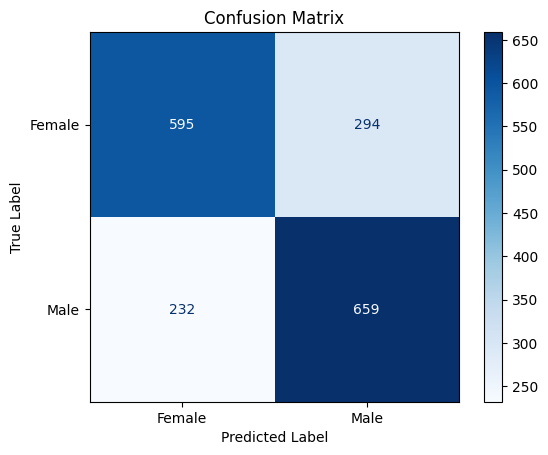

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

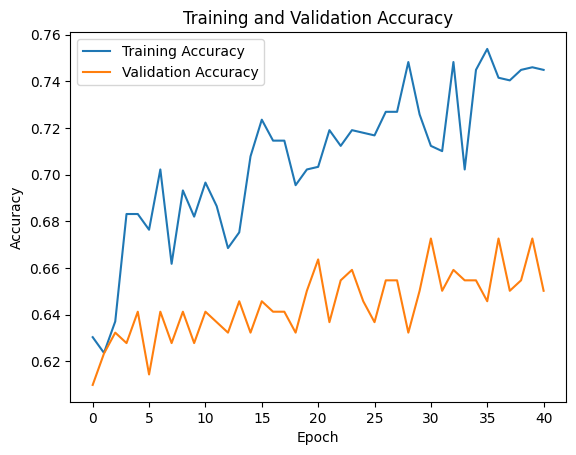

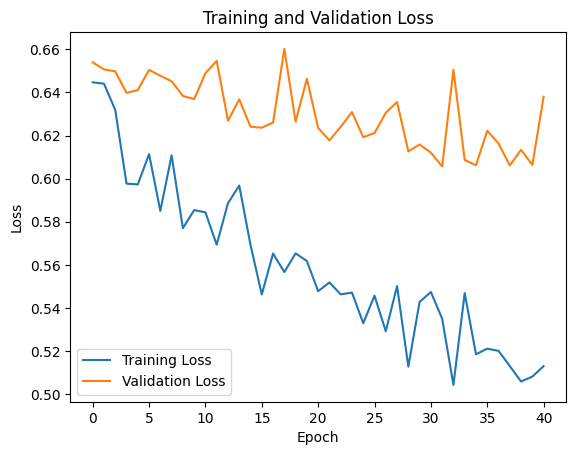

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()